# BlackJack : Monte-Carlo with Exploring Start
----

## 설명
블랙잭 게임에서의 최적 Policy를 찾는 프로그램입니다. 본 프로그램에서 정의된 블랙잭 룰은 다음과 같습니다.
 - 하나의 카드 덱(조커를 제외한 52장의 카드)을 사용
 - 카드의 합을 계산할 시 A = 1 or 11, J,Q,K = 10으로 계산
 - 플레이어는 Hit 또는 Stick만을 할 수 있음
 - 카드의 합이 21 이하일 경우, 딜러와 플레이어 중 숫자가 더 높은 쪽이 승리.
 - 카드의 합이 21 초과한 딜러/플레이어는 패배
 - 카드의 합이 같을 경우 무승부

본 프로그램에서는 최적 Policy를 찾기 위해 Monte-Carlo Control with Exploring Start[1] 알고리즘을 사용합니다. 최적 Policy를 찾기 위해, 본 프로그램은 다음과 같은 변수로 구성된 State로부터 탐색을 수행합니다.
 - 플레이어 카드의 합 : 12 ~ 21 사이의 정수
 - 딜러가 보여주는 카드의 숫자 : 1 ~ 10 사이의 정수
 - 플레이어가 현재 사용 가능한 Ace의 유무 : True / False

위와 같이 구성된 State S에서 Action A를 선택했을 때의 기대 리턴(게임이 끝났을 때 얻을 것으로 기대되는 보상의 합)은 Q(S,A)입니다. 많은 에피소드를 경험할수혹 Agent는 Optimal Q(S,A)에 가까운 값을 학습하게 되며, 이로부터 최적 Policy를 찾을 수 있습니다.

----

## 0. Package
먼저 본 프로그램에서 사용할 Package를 Import합니다.

In [1345]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

## 1. Class : Deck
카드 덱 한 벌에 해당하는 클래스를 선언합니다. 조커를 제외한 52장의 카드로 이루어져 있으며, 각 카드는 정수로 표기됩니다. <br>
A = 11, J, Q, K = 10으로 표현되며, 나머지 카드는 해당 카드에 적힌 숫자만큼의 값을 갖습니다.

### 클래스 구성
* Attributes
   * card_deck : List, 52개의 정수로 이루어짐
* Methods
   * shuffle() : 카드 덱을 랜덤하게 섞음
   * draw() : 카드 덱에서 한 장을 뽑아 리턴
   * reset() : 카드 덱을 초기화함

In [1346]:
class Deck(object):
    """
    Deck : Card deck, which can be shuffled, drawn, and reset.
    """

    def __init__(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]    #black jack card
        self.card_deck = deck * 4                       #4개씩의 카드 만들기
        self.shuffle()

    def shuffle(self):
        random.shuffle(self.card_deck)

    def draw(self):
        return self.card_deck.pop()

    def reset(self):
#         deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
#             self.card_deck = deck * 4
#             self.shuffle()                     #셔플
        if(len(self.card_deck)<15):
            #print("딜러 셔플\n")
            deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
            new_deck = deck * 4
            random.shuffle(new_deck)                  #셔플
            self.card_deck+=new_deck
            return True
        else:
            return False

## 2. Class : Dealer
다음으로 Dealer 클래스를 선언합니다.<br> 
Dealer 클래스는 강화학습에서의 Environment에 해당합니다. 플레이어의 Action을 받고, 그에 따른 다음 State와 Reward를 반환합니다.<br>
딜러는 시작할 때 두 장의 카드를 받습니다. 플레이어의 차례가 끝난 후, 플레이어의 카드 합이 21을 넘지 않는다면 딜러는 다음과 같이 행동합니다.
 - 딜러 카드의 합이 17 미만일 때 : 카드 한 장을 추가로 뽑음 (Hit)
 - 딜러 카드의 합이 17 이상일 때 : 플레이어의 카드 합과 비교하여 승패 결정 (Stick)

### 클래스 구성
딜러 클래스는 다음과 같이 구성됩니다
 - Attributes
     - hands : List, 딜러가 가지고 있는 카드들
     - usable_ace : List, 딜러가 가지고 있는 A의 인덱스
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - show() : 딜러가 가진 카드 중 랜덤한 한 장의 값을 리턴
     - calculate_sum() : 딜러가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - action() : 딜러의 Action - 합이 17 미만이면 hit, 이상이면 stick
     - observation(action, agent, deck) : 플레이어의 action을 받아 종료 여부와 reward 리턴
     - calculate_rewards(agent, deck) : 플레이어와 딜러의 승패 계산 및 reward 리턴
     - reset() : 딜러 클래스의 모든 attribute 초기화

In [1347]:
class Dealer(object):
    """
    Dealer : 딜러 클래스
    딜러는 두 장의 카드를 받고, 카드의 합이 16 이하이면 Hit, 17이상이면 Stick 함.
    처음 두 장을 받았을 때 한 장의 카드를 랜덤하게 오픈함.
    """

    def __init__(self):
        """
        hand : 딜러가 가진 카드
        usable_ace : 딜러가 가진 카드 리스트 중 ace의 인덱스
        natural : 두 장의 카드로 21이 되면 True, 아니면 False
        """
        self.hands = list()                      #딜러가 가지고 있는 카드들
        self.usable_ace = list()                 #딜러가 가지고 있는 에이스의 인덱스
        self.running_counting=0                  #running counting 2개의 카드 카운팅
        self.show_card_counting=0                #show_card_counting 보여준 카드 카운팅

    def hit(self, deck: Deck):
        """
        딜러의 Hit. 새로운 카드가 Ace라면 사용 가능한 Ace 리스트에 추가함
        :param deck: Deck Object
        :return:
        """
        new_card = deck.draw()                   #hit할 경우 카드 드로우
        #print("딜러가 {:d} 카드 한장을 뽑습니다.\n".format(new_card))
        
        if new_card<=6:
            self.running_counting+=1             # 카드 카운팅
        elif new_card>=10:
            self.running_counting-=1             # 카드 카운팅
            
        if new_card == 11:                       # 새 카드가 11이면
            self.usable_ace.append(len(self.hands))    #에이스 리스트에 넣는다
        self.hands.append(new_card)              #가지고 있는 카드를 핸드에 넣음
        

    def show(self):
        """
        딜러가 가진 카드 중 하나를 랜덤하게 보여줌
        :return: 딜러의 카드 중 랜덤한 카드 숫자
        """
        
        card = random.choice(self.hands)        #딜러가 가진 카드 중 하나를 랜덤하게 보여줌
        
        if card<=6:
            self.show_card_counting+=1          #보여준 카드 카운팅
        elif card>=10:
            self.show_card_counting-=1          #보여준 카드 카운팅
            
        if card == 11:                          #card가 11이면
            card = 1                               #에이스 card
            
        #print("나온 카드는 {:d}\n".format(card))
        return card

    def calculate_sum(self):
        """
        딜러가 가진 카드의 합을 구함
        21을 넘을 때 사용 가능한 Ace가 있으면 사용함
        :return: 딜러 카드의 합
        """
        sums = sum(self.hands)                 #가지고 있는 카드들 총 계산
        if sums > 21 and len(self.usable_ace) > 0:    #만약 21이 넘고 에이스가 있으면
            self.hands[self.usable_ace.pop()] = 1          #에이스를 1로 계산
            sums = sum(self.hands)
        return sums

    def action(self, deck: Deck):
        """
        딜러의 순서 때 딜러의 행동.
        숫자의 합이 16 이하일 때는 Hit, 17 이상이면 Stick
        :param deck:
        :return:
        """
        while True:
            sums = self.calculate_sum()     
            if sums < 17:                   #합이 17보다 작을 경우 hit
                self.hit(deck)                  
            else:
                return sums                 #17을 넘으면 return

    def observation(self, action, agent, deck):
        """
        플레이어의 Action을 받아, 그에 맞는 Observation과 Reward를 반환
        :param action: agent 의 Action
        :param agent: agent 클래스
        :param deck: deck 클래스
        :return: 에피소드 종료 여부, reward
        """
        done = False
        reward = 0
        
        if action[0] == True:  # Hit
            agent.hit(deck)  #현재 덱에서 한장을 뽑게함
            if agent.calculate_sum() > 21:  #플레이어의 Hit으로 인해 카드 합이 21이 넘으면 즉시 종료
                done = True
                reward = -1*action[1]
                
        else:  # Stick
            done = True       
            reward = self.calcuate_reward(agent, deck, action[1]) #agent의 덱을 계산

        return done, reward

    def calcuate_reward(self, agent, deck, bet):
        """
        플레이어가 Stick했을 때 딜러와의 카드 비교 수행
        :param agent:
        :param deck:
        :return: Reward
        """
        agent_sum = agent.calculate_sum()           # 플레이어의 카드 합 계산
        if agent_sum > 21:                          # 플레이어의 Bust (패)
        #    print("플레이어가 burst 되었습니다. 플레이어 패배\n")
            return -1*bet

        dealer_sum = self.action(deck)              # 딜러의 카드 합 계산
        if dealer_sum > 21:                         # 딜러가 Bust (승)
        #    print("딜러가 burst 되었습니다. 플레이어 승리\n")
            return 1*bet
        if dealer_sum > agent_sum:                  # 딜러의 카드 합 > 플레이어 합 (패)
        #    print("딜러가 이겼습니다. 플레이어 패배\n")
            return -1*bet
        if dealer_sum < agent_sum:                  # 딜러의 카드 합 < 플레이어 합 (승)
        #    print("플레이어가 이겼습니다.\n")
            return 1*bet
        #print("무승부 입니다.\n")
        return 0                                   # 딜러의 카드 합 == 플레이어의 합 (무)

    def reset(self):
        """
        딜러 초기화 (새로운 에피소드 시작을 위해)
        """
        #print("새로운 게임을 시작합니다.\n")
        self.running_counting=0
        self.show_card_counting=0
        self.hands = list()          #딜러 초기화
        self.usable_ace = list()     #딜러 초기화

## 3. Class : Agent
Agent 클래스는 플레이어에 해당하며, 최적 Policy를 학습하는 주체가 됩니다. Agent는 여러 에피소드들로부터 Q값(기대 Return)을 계산하고, 다음 에피소드 수행 시 해당 State에서 Q값이 높은 Action을 선택하는 Greedy Policy를 따릅니다. 

### 클래스 구성

Agent의 구성은 다음과 같습니다.

 - Attributes
     - hands : List, Agent가 가지고 있는 카드들
     - usable_ace : List, Agent가 가지고 있는 A의 인덱스
     - Q_table : Dictionary, 기대 Return값과 방문 횟수를 저장
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - calculate_sum() : Agent가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - random_action() : 현재 State에 상관없이 랜덤하게 Action을 리턴
     - policy(state) : 현재 State에서 가능한 Action 중, Q_table의 값이 큰 Action을 리턴
     - update_qval(episode) : 에피소드로부터 평균 리턴을 계산하여 Q_table을 업데이트
     - reset() : Agent 클래스의 모든 attribute 초기화

In [1348]:
class Agent(object):
    def __init__(self):
        """
        hand : 플레이어의 카드
        usable_ace : 사용 가능한 ace 리스트
        Q_table : q(s,a) 값을 저장할 딕셔너리
        """
        self.hands = list()        #플레이어의 카드
        self.usable_ace = list()    #에이스 여부
        self.Q_table = dict()       #기대값
        self.running_counting=0      #카드 카운팅

    def hit(self, deck: Deck):
        """
        덱에서 새로운 카드를 뽑음
        :param deck: Deck for draw a card
        :return: None
        """
        new_card = deck.draw()     #새 카드를 뽑는다
        #print("플레이어가 추가 {:d} 카드를 뽑습니다.\n ".format(new_card))
        
        if new_card<=6:
            self.running_counting+=1     #새 카드 카운팅
        elif new_card>=10:
            self.running_counting-=1
            
        if new_card == 11:            #11이면
            self.usable_ace.append(len(self.hands))  #에이스를 저장
        
        self.hands.append(new_card)      

    def calculate_sum(self):
        """
        플레이어가 가진 카드의 합을 구함.
        21을 넘을 때 사용 가능한 ace가 있으면 사용함
        :return:
        """
        sums = sum(self.hands)                        #합 계산
        if sums > 21 and len(self.usable_ace) > 0:    #21이 넘고 에이스가 있으면
            self.hands[self.usable_ace.pop()] = 1     #에이스를 1로 계산
            sums = sum(self.hands)
        return sums

    def random_action(self):
        """
        랜덤하게 행동
        True = hit, False = stick
        :return:
        """
        return random.choice([True, False]), random.choice([1,30])    #랜덤하게 행동

    def policy(self, state):
        """
        Agent의 policy 함수.
        e의 확률로 랜덤 행동을 하며, 그 외에는 현재 state에서 큰 q(s,a)값을 갖는 action을 선택함
        :param state: Agent에게 주어진 state
        :return: agent의 action을 반환 , True = hit and False = stick
        """
        # Q_table에서 현재 state-action에 대해 값이 존재하는지 검사함
        for action in ((True,1), (True, 30), (False,1), (False,30)):
            if (state, action) not in self.Q_table.keys():  # Q_table에 값이 없으면 0으로 초기화
                self.Q_table[(state, action)] = [0, 0]      # (mean return, visit count)
            else:
                continue

        # q값이 큰 action 선택     
        
        temp = self.Q_table[(state, (True,1))]
        max_bet=1
        act=True
        
        if temp < self.Q_table[(state, (True,30))]:
            max_bet=30
            act=True
            temp=self.Q_table[(state,(True,30))]
        elif temp < self.Q_table[(state,(False,1))]:
            max_bet=1
            act=False
            temp=self.Q_table[(state,(False,1))]
        elif temp < self.Q_table[(state,(False,30))]:
            max_bet=30
            act=False
        
        return act,max_bet

    def reset(self):
        """
        Agent를 리셋함
        :return: None
        """
        self.hands = list()             #Agent 리셋
        self.usable_ace = list()         #에이스 리셋

    def update_qval(self, episode):
        """
        에피소드(한 번의 게임)으로부터 Q_table 을 업데이트함
        Q 테이블에 없는 state-action 쌍이 나오면 새로 생성
        Q 테이블에 state-action 쌍이 존재한다면 Incremental mean 적용하여 업데이트
        :param episode: Episode generated from environment
        :return: None
        """
        total_return = 0
        for state, action, reward in episode[::-1]:     # 에피소드의 뒤에서부터 (역순)
            total_return += reward                       # return Gt 계산
            if (state, action) not in self.Q_table.keys():  # state-action 쌍이 없다면
                self.Q_table[(state, action)] = [total_return, 1]   # 새롭게 엔트리 생성 (Gt, count)

            else:  #이미 존재하는 state-action 쌍이면 Incremental mean 적용
                prev_val = self.Q_table[(state, action)][0]         # 이전의 평균 return
                count = self.Q_table[(state, action)][1] + 1        # count 증가
                mean = prev_val + (total_return - prev_val) / count # 평균 계산 : Incremental Mean 적용
                self.Q_table[(state, action)] = [mean, count]  # 업데이트

## 4. Class : MonteCarlo
Monte-Carlo control with Exploring Start를 구현한 클래스입니다. 에피소드를 생성할 수 있고, 생성된 에피소드로부터 에이전트를 학습시킵니다.
에피소드 생성 시 Exploring Start를 위해 에피소드의 첫 번째 State에서는 무작위로 Action을 선택하며, 이후에는 에이전트의 Policy를 따라 Action을 선택합니다.

### 클래스 구성
MonteCarlo 클래스는 다음과 같이 구성됩니다.
 - Attribute
     - 없음
 - Methods 
     - generate_episode(dealer, agent, deck) : 딜러, 플레이어, 카드 덱을 이용해 한 번의 블랙잭 게임을 진행하고 에피소드를 반환합니다.
     - train(dealer, agent, deck, it, verbose) : 지정된 이터레이션 수만큼의 에피소드로부터 플레이어를 학습시킵니다.

In [1349]:
class MonteCarlo(object):
    
    def generate_episode(self, dealer: Dealer, agent: Agent, deck: Deck):
        """
        하나의 에피소드(게임)를 생성함
        :param dealer:
        :param agent:
        :param deck:
        :return:
        """
        
        # 카드 덱, 딜러, Agent를 초기화
        reset=deck.reset()
        
        if(reset==True):
            agent.running_counting=0         #reset 할 경우 running_counting 초기화
            
        dealer.reset()
        agent.reset()
        agent.hit(deck)
        agent.hit(deck)
        dealer.hit(deck)
        dealer.hit(deck)
        
        done = False    # 에피소드의 종료 여부

        episode = list()    # 에피소드

        while not done:
            # 에피소드가 끝날 때까지 State, Action, Reward를 생성
            sums = agent.calculate_sum()
            
            if sums < 12:
                agent.hit(deck)
                continue
            
            dealer.show()
            
            counting=agent.running_counting+dealer.show_card_counting
                
            state=(sums, bool(agent.usable_ace), counting)
            #state에 agent의 counting+dealer가 보여준 카운팅 나누기 현재 카드 남은 개수를 상태로 저장

            ########   Exploring Start ~!!!!!!!!! : 
            if len(episode) == 0:       # 첫번째 State 일 때는 무작위 Action 선택
                action = agent.random_action()
                
            else:                       # 그 외에는 Q 테이블에서 큰 값을 갖는 Action 선택
                action = agent.policy(state)
            
            done, reward = dealer.observation(action, agent, deck)  # 에피소드 종료 여부, Reward 계산
            
            # 생성된 State, Action, Reward를 에피소드에 추가
            episode.append([state, action, reward])

        agent.running_counting+=dealer.running_counting
        return episode

    def train(self, dealer: Dealer, agent: Agent, deck: Deck, it, verbose=True):
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        result = str()
        for i in range(it):
            count += 1
            episode = self.generate_episode(dealer, agent, deck)
            agent.update_qval(episode)

            if episode[-1][-1] > 0:
                win += 1
            elif episode[-1][-1] == 0:
                draw += 1
            else:
                loss += 1

            if count % 1000 == 0 and verbose == True:
                total_win += win
                total_loss += loss
                total_draw += draw

                print("========== Training : Episode ", count, " ===========")
                print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
                print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
                print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
                print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)

                win = 0
                loss = 0
                draw = 0
                

## 5. Function : plot_q_val(agent, usable_ace)
Q값을 시각화하기 위한 함수입니다.

In [1350]:
def plot_q_val(agent: Agent, usable_ace=True):
    fig = plt.figure()
    ax = Axes3D(fig)

    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])   #2번째 index 추가

    Z_list = list()

    l = list()

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            v_val = max([agent.Q_table[((hand, usable_ace, d), True)][0], agent.Q_table[((hand, usable_ace, d), False)][0]])
            l.append(v_val)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)

    Z = np.array(Z_list).T

    ax.plot_wireframe(X, Y, Z)
    plt.show()

## 6. Function : plot_q_val(agent, usable_ace)
최적 Policy를 시각화하기 위한 함수입니다.

In [1351]:
def plot_action(agent: Agent, usable_ace=True):
    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    action = False

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), (True,1)) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), (True,5)) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), (False,1)) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            if ((hand, usable_ace, d), (False,5)) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            l.append(0 if agent.Q_table[((hand, usable_ace, d), True)][0] > agent.Q_table[((hand, usable_ace, d), False)][0] else 1)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)
    Z = np.array(Z_list).T

    data = Z[::-1,:]
    data = np.append(data, [0 for _ in range(Z[0].shape[0])]).reshape(-1,Z[0].shape[0])
    
    cmap=cm.coolwarm
    plt.imshow(data, cmap=cmap, extent=[1,11,11,21])

    plt.show()
    return X, Y, Z

## 7. 최적 Policy 학습


In [1352]:
deck = Deck()
dealer = Dealer()
agent = Agent()
mc_es = MonteCarlo()

mc_es.train(dealer, agent, deck, it=1000000)

========== Training : Episode  1000  ===========
Recent 1000 games win rate :32.221%
 -- 1000 Games WIN : 309 DRAW : 41 LOSS : 650
Total win rate : 32.221%
 -- TOTAL Games WIN : 309 DRAW : 41 LOSS : 650
========== Training : Episode  2000  ===========
Recent 1000 games win rate :35.865%
 -- 1000 Games WIN : 340 DRAW : 52 LOSS : 608
Total win rate : 34.033%
 -- TOTAL Games WIN : 649 DRAW : 93 LOSS : 1258
========== Training : Episode  3000  ===========
Recent 1000 games win rate :36.508%
 -- 1000 Games WIN : 345 DRAW : 55 LOSS : 600
Total win rate : 34.853%
 -- TOTAL Games WIN : 994 DRAW : 148 LOSS : 1858
========== Training : Episode  4000  ===========
Recent 1000 games win rate :33.948%
 -- 1000 Games WIN : 313 DRAW : 78 LOSS : 609
Total win rate : 34.632%
 -- TOTAL Games WIN : 1307 DRAW : 226 LOSS : 2467
========== Training : Episode  5000  ===========
Recent 1000 games win rate :34.936%
 -- 1000 Games WIN : 327 DRAW : 64 LOSS : 609
Total win rate : 34.692%
 -- TOTAL Games WIN : 1634

========== Training : Episode  50000  ===========
Recent 1000 games win rate :32.147%
 -- 1000 Games WIN : 298 DRAW : 73 LOSS : 629
Total win rate : 35.183%
 -- TOTAL Games WIN : 16561 DRAW : 2929 LOSS : 30510
========== Training : Episode  51000  ===========
Recent 1000 games win rate :37.500%
 -- 1000 Games WIN : 354 DRAW : 56 LOSS : 590
Total win rate : 35.229%
 -- TOTAL Games WIN : 16915 DRAW : 2985 LOSS : 31100
========== Training : Episode  52000  ===========
Recent 1000 games win rate :36.547%
 -- 1000 Games WIN : 345 DRAW : 56 LOSS : 599
Total win rate : 35.254%
 -- TOTAL Games WIN : 17260 DRAW : 3041 LOSS : 31699
========== Training : Episode  53000  ===========
Recent 1000 games win rate :34.677%
 -- 1000 Games WIN : 327 DRAW : 57 LOSS : 616
Total win rate : 35.243%
 -- TOTAL Games WIN : 17587 DRAW : 3098 LOSS : 32315
========== Training : Episode  54000  ===========
Recent 1000 games win rate :32.944%
 -- 1000 Games WIN : 310 DRAW : 59 LOSS : 631
Total win rate : 35.201%
 --

========== Training : Episode  91000  ===========
Recent 1000 games win rate :37.104%
 -- 1000 Games WIN : 351 DRAW : 54 LOSS : 595
Total win rate : 35.201%
 -- TOTAL Games WIN : 30147 DRAW : 5357 LOSS : 55496
========== Training : Episode  92000  ===========
Recent 1000 games win rate :35.036%
 -- 1000 Games WIN : 336 DRAW : 41 LOSS : 623
Total win rate : 35.199%
 -- TOTAL Games WIN : 30483 DRAW : 5398 LOSS : 56119
========== Training : Episode  93000  ===========
Recent 1000 games win rate :34.947%
 -- 1000 Games WIN : 332 DRAW : 50 LOSS : 618
Total win rate : 35.196%
 -- TOTAL Games WIN : 30815 DRAW : 5448 LOSS : 56737
========== Training : Episode  94000  ===========
Recent 1000 games win rate :35.722%
 -- 1000 Games WIN : 334 DRAW : 65 LOSS : 601
Total win rate : 35.202%
 -- TOTAL Games WIN : 31149 DRAW : 5513 LOSS : 57338
========== Training : Episode  95000  ===========
Recent 1000 games win rate :34.295%
 -- 1000 Games WIN : 321 DRAW : 64 LOSS : 615
Total win rate : 35.192%
 --

========== Training : Episode  133000  ===========
Recent 1000 games win rate :37.460%
 -- 1000 Games WIN : 354 DRAW : 55 LOSS : 591
Total win rate : 35.164%
 -- TOTAL Games WIN : 44037 DRAW : 7766 LOSS : 81197
========== Training : Episode  134000  ===========
Recent 1000 games win rate :33.548%
 -- 1000 Games WIN : 313 DRAW : 67 LOSS : 620
Total win rate : 35.152%
 -- TOTAL Games WIN : 44350 DRAW : 7833 LOSS : 81817
========== Training : Episode  135000  ===========
Recent 1000 games win rate :36.617%
 -- 1000 Games WIN : 342 DRAW : 66 LOSS : 592
Total win rate : 35.163%
 -- TOTAL Games WIN : 44692 DRAW : 7899 LOSS : 82409
========== Training : Episode  136000  ===========
Recent 1000 games win rate :38.624%
 -- 1000 Games WIN : 365 DRAW : 55 LOSS : 580
Total win rate : 35.188%
 -- TOTAL Games WIN : 45057 DRAW : 7954 LOSS : 82989
========== Training : Episode  137000  ===========
Recent 1000 games win rate :34.755%
 -- 1000 Games WIN : 326 DRAW : 62 LOSS : 612
Total win rate : 35.185

========== Training : Episode  177000  ===========
Recent 1000 games win rate :35.837%
 -- 1000 Games WIN : 334 DRAW : 68 LOSS : 598
Total win rate : 35.170%
 -- TOTAL Games WIN : 58596 DRAW : 10393 LOSS : 108011
========== Training : Episode  178000  ===========
Recent 1000 games win rate :32.489%
 -- 1000 Games WIN : 308 DRAW : 52 LOSS : 640
Total win rate : 35.155%
 -- TOTAL Games WIN : 58904 DRAW : 10445 LOSS : 108651
========== Training : Episode  179000  ===========
Recent 1000 games win rate :32.618%
 -- 1000 Games WIN : 304 DRAW : 68 LOSS : 628
Total win rate : 35.141%
 -- TOTAL Games WIN : 59208 DRAW : 10513 LOSS : 109279
========== Training : Episode  180000  ===========
Recent 1000 games win rate :35.722%
 -- 1000 Games WIN : 339 DRAW : 51 LOSS : 610
Total win rate : 35.144%
 -- TOTAL Games WIN : 59547 DRAW : 10564 LOSS : 109889
========== Training : Episode  181000  ===========
Recent 1000 games win rate :35.707%
 -- 1000 Games WIN : 341 DRAW : 45 LOSS : 614
Total win rate 

========== Training : Episode  228000  ===========
Recent 1000 games win rate :33.156%
 -- 1000 Games WIN : 311 DRAW : 62 LOSS : 627
Total win rate : 35.210%
 -- TOTAL Games WIN : 75550 DRAW : 13430 LOSS : 139020
========== Training : Episode  229000  ===========
Recent 1000 games win rate :37.514%
 -- 1000 Games WIN : 347 DRAW : 75 LOSS : 578
Total win rate : 35.220%
 -- TOTAL Games WIN : 75897 DRAW : 13505 LOSS : 139598
========== Training : Episode  230000  ===========
Recent 1000 games win rate :33.544%
 -- 1000 Games WIN : 319 DRAW : 49 LOSS : 632
Total win rate : 35.212%
 -- TOTAL Games WIN : 76216 DRAW : 13554 LOSS : 140230
========== Training : Episode  231000  ===========
Recent 1000 games win rate :33.970%
 -- 1000 Games WIN : 320 DRAW : 58 LOSS : 622
Total win rate : 35.207%
 -- TOTAL Games WIN : 76536 DRAW : 13612 LOSS : 140852
========== Training : Episode  232000  ===========
Recent 1000 games win rate :34.677%
 -- 1000 Games WIN : 327 DRAW : 57 LOSS : 616
Total win rate 

========== Training : Episode  268000  ===========
Recent 1000 games win rate :36.123%
 -- 1000 Games WIN : 341 DRAW : 56 LOSS : 603
Total win rate : 35.201%
 -- TOTAL Games WIN : 88781 DRAW : 15785 LOSS : 163434
========== Training : Episode  269000  ===========
Recent 1000 games win rate :34.345%
 -- 1000 Games WIN : 317 DRAW : 77 LOSS : 606
Total win rate : 35.197%
 -- TOTAL Games WIN : 89098 DRAW : 15862 LOSS : 164040
========== Training : Episode  270000  ===========
Recent 1000 games win rate :33.087%
 -- 1000 Games WIN : 314 DRAW : 51 LOSS : 635
Total win rate : 35.190%
 -- TOTAL Games WIN : 89412 DRAW : 15913 LOSS : 164675
========== Training : Episode  271000  ===========
Recent 1000 games win rate :34.141%
 -- 1000 Games WIN : 324 DRAW : 51 LOSS : 625
Total win rate : 35.186%
 -- TOTAL Games WIN : 89736 DRAW : 15964 LOSS : 165300
========== Training : Episode  272000  ===========
Recent 1000 games win rate :34.072%
 -- 1000 Games WIN : 323 DRAW : 52 LOSS : 625
Total win rate 

========== Training : Episode  312000  ===========
Recent 1000 games win rate :37.671%
 -- 1000 Games WIN : 359 DRAW : 47 LOSS : 594
Total win rate : 35.226%
 -- TOTAL Games WIN : 103434 DRAW : 18369 LOSS : 190197
========== Training : Episode  313000  ===========
Recent 1000 games win rate :38.300%
 -- 1000 Games WIN : 365 DRAW : 47 LOSS : 588
Total win rate : 35.236%
 -- TOTAL Games WIN : 103799 DRAW : 18416 LOSS : 190785
========== Training : Episode  314000  ===========
Recent 1000 games win rate :33.828%
 -- 1000 Games WIN : 319 DRAW : 57 LOSS : 624
Total win rate : 35.231%
 -- TOTAL Games WIN : 104118 DRAW : 18473 LOSS : 191409
========== Training : Episode  315000  ===========
Recent 1000 games win rate :37.672%
 -- 1000 Games WIN : 356 DRAW : 55 LOSS : 589
Total win rate : 35.239%
 -- TOTAL Games WIN : 104474 DRAW : 18528 LOSS : 191998
========== Training : Episode  316000  ===========
Recent 1000 games win rate :35.394%
 -- 1000 Games WIN : 332 DRAW : 62 LOSS : 606
Total win r

========== Training : Episode  356000  ===========
Recent 1000 games win rate :36.170%
 -- 1000 Games WIN : 340 DRAW : 60 LOSS : 600
Total win rate : 35.254%
 -- TOTAL Games WIN : 118126 DRAW : 20929 LOSS : 216945
========== Training : Episode  357000  ===========
Recent 1000 games win rate :31.529%
 -- 1000 Games WIN : 297 DRAW : 58 LOSS : 645
Total win rate : 35.244%
 -- TOTAL Games WIN : 118423 DRAW : 20987 LOSS : 217590
========== Training : Episode  358000  ===========
Recent 1000 games win rate :35.363%
 -- 1000 Games WIN : 331 DRAW : 64 LOSS : 605
Total win rate : 35.244%
 -- TOTAL Games WIN : 118754 DRAW : 21051 LOSS : 218195
========== Training : Episode  359000  ===========
Recent 1000 games win rate :32.384%
 -- 1000 Games WIN : 307 DRAW : 52 LOSS : 641
Total win rate : 35.236%
 -- TOTAL Games WIN : 119061 DRAW : 21103 LOSS : 218836
========== Training : Episode  360000  ===========
Recent 1000 games win rate :33.544%
 -- 1000 Games WIN : 318 DRAW : 52 LOSS : 630
Total win r

========== Training : Episode  398000  ===========
Recent 1000 games win rate :35.895%
 -- 1000 Games WIN : 341 DRAW : 50 LOSS : 609
Total win rate : 35.185%
 -- TOTAL Games WIN : 131832 DRAW : 23319 LOSS : 242849
========== Training : Episode  399000  ===========
Recent 1000 games win rate :30.172%
 -- 1000 Games WIN : 280 DRAW : 72 LOSS : 648
Total win rate : 35.173%
 -- TOTAL Games WIN : 132112 DRAW : 23391 LOSS : 243497
========== Training : Episode  400000  ===========
Recent 1000 games win rate :34.737%
 -- 1000 Games WIN : 330 DRAW : 50 LOSS : 620
Total win rate : 35.172%
 -- TOTAL Games WIN : 132442 DRAW : 23441 LOSS : 244117
========== Training : Episode  401000  ===========
Recent 1000 games win rate :36.461%
 -- 1000 Games WIN : 342 DRAW : 62 LOSS : 596
Total win rate : 35.175%
 -- TOTAL Games WIN : 132784 DRAW : 23503 LOSS : 244713
========== Training : Episode  402000  ===========
Recent 1000 games win rate :33.015%
 -- 1000 Games WIN : 311 DRAW : 58 LOSS : 631
Total win r

 -- 1000 Games WIN : 328 DRAW : 59 LOSS : 613
Total win rate : 35.217%
 -- TOTAL Games WIN : 144851 DRAW : 25692 LOSS : 266457
========== Training : Episode  438000  ===========
Recent 1000 games win rate :34.100%
 -- 1000 Games WIN : 326 DRAW : 44 LOSS : 630
Total win rate : 35.215%
 -- TOTAL Games WIN : 145177 DRAW : 25736 LOSS : 267087
========== Training : Episode  439000  ===========
Recent 1000 games win rate :33.262%
 -- 1000 Games WIN : 311 DRAW : 65 LOSS : 624
Total win rate : 35.210%
 -- TOTAL Games WIN : 145488 DRAW : 25801 LOSS : 267711
========== Training : Episode  440000  ===========
Recent 1000 games win rate :40.127%
 -- 1000 Games WIN : 378 DRAW : 58 LOSS : 564
Total win rate : 35.221%
 -- TOTAL Games WIN : 145866 DRAW : 25859 LOSS : 268275
========== Training : Episode  441000  ===========
Recent 1000 games win rate :33.583%
 -- 1000 Games WIN : 314 DRAW : 65 LOSS : 621
Total win rate : 35.218%
 -- TOTAL Games WIN : 146180 DRAW : 25924 LOSS : 268896
========== Traini

========== Training : Episode  483000  ===========
Recent 1000 games win rate :36.720%
 -- 1000 Games WIN : 347 DRAW : 55 LOSS : 598
Total win rate : 35.213%
 -- TOTAL Games WIN : 160080 DRAW : 28401 LOSS : 294519
========== Training : Episode  484000  ===========
Recent 1000 games win rate :35.470%
 -- 1000 Games WIN : 332 DRAW : 64 LOSS : 604
Total win rate : 35.214%
 -- TOTAL Games WIN : 160412 DRAW : 28465 LOSS : 295123
========== Training : Episode  485000  ===========
Recent 1000 games win rate :34.081%
 -- 1000 Games WIN : 319 DRAW : 64 LOSS : 617
Total win rate : 35.212%
 -- TOTAL Games WIN : 160731 DRAW : 28529 LOSS : 295740
========== Training : Episode  486000  ===========
Recent 1000 games win rate :35.827%
 -- 1000 Games WIN : 340 DRAW : 51 LOSS : 609
Total win rate : 35.213%
 -- TOTAL Games WIN : 161071 DRAW : 28580 LOSS : 296349
========== Training : Episode  487000  ===========
Recent 1000 games win rate :34.834%
 -- 1000 Games WIN : 325 DRAW : 67 LOSS : 608
Total win r

========== Training : Episode  534000  ===========
Recent 1000 games win rate :34.154%
 -- 1000 Games WIN : 319 DRAW : 66 LOSS : 615
Total win rate : 35.253%
 -- TOTAL Games WIN : 177168 DRAW : 31445 LOSS : 325387
========== Training : Episode  535000  ===========
Recent 1000 games win rate :34.792%
 -- 1000 Games WIN : 326 DRAW : 63 LOSS : 611
Total win rate : 35.253%
 -- TOTAL Games WIN : 177494 DRAW : 31508 LOSS : 325998
========== Training : Episode  536000  ===========
Recent 1000 games win rate :35.388%
 -- 1000 Games WIN : 333 DRAW : 59 LOSS : 608
Total win rate : 35.253%
 -- TOTAL Games WIN : 177827 DRAW : 31567 LOSS : 326606
========== Training : Episode  537000  ===========
Recent 1000 games win rate :35.432%
 -- 1000 Games WIN : 332 DRAW : 63 LOSS : 605
Total win rate : 35.253%
 -- TOTAL Games WIN : 178159 DRAW : 31630 LOSS : 327211
========== Training : Episode  538000  ===========
Recent 1000 games win rate :34.599%
 -- 1000 Games WIN : 319 DRAW : 78 LOSS : 603
Total win r

========== Training : Episode  575000  ===========
Recent 1000 games win rate :34.764%
 -- 1000 Games WIN : 324 DRAW : 68 LOSS : 608
Total win rate : 35.261%
 -- TOTAL Games WIN : 190818 DRAW : 33835 LOSS : 350347
========== Training : Episode  576000  ===========
Recent 1000 games win rate :37.712%
 -- 1000 Games WIN : 356 DRAW : 56 LOSS : 588
Total win rate : 35.265%
 -- TOTAL Games WIN : 191174 DRAW : 33891 LOSS : 350935
========== Training : Episode  577000  ===========
Recent 1000 games win rate :34.530%
 -- 1000 Games WIN : 327 DRAW : 53 LOSS : 620
Total win rate : 35.264%
 -- TOTAL Games WIN : 191501 DRAW : 33944 LOSS : 351555
========== Training : Episode  578000  ===========
Recent 1000 games win rate :33.262%
 -- 1000 Games WIN : 310 DRAW : 68 LOSS : 622
Total win rate : 35.260%
 -- TOTAL Games WIN : 191811 DRAW : 34012 LOSS : 352177
========== Training : Episode  579000  ===========
Recent 1000 games win rate :34.049%
 -- 1000 Games WIN : 317 DRAW : 69 LOSS : 614
Total win r

========== Training : Episode  617000  ===========
Recent 1000 games win rate :36.190%
 -- 1000 Games WIN : 342 DRAW : 55 LOSS : 603
Total win rate : 35.283%
 -- TOTAL Games WIN : 204887 DRAW : 36300 LOSS : 375813
========== Training : Episode  618000  ===========
Recent 1000 games win rate :37.658%
 -- 1000 Games WIN : 357 DRAW : 52 LOSS : 591
Total win rate : 35.287%
 -- TOTAL Games WIN : 205244 DRAW : 36352 LOSS : 376404
========== Training : Episode  619000  ===========
Recent 1000 games win rate :34.180%
 -- 1000 Games WIN : 323 DRAW : 55 LOSS : 622
Total win rate : 35.285%
 -- TOTAL Games WIN : 205567 DRAW : 36407 LOSS : 377026
========== Training : Episode  620000  ===========
Recent 1000 games win rate :33.723%
 -- 1000 Games WIN : 317 DRAW : 60 LOSS : 623
Total win rate : 35.282%
 -- TOTAL Games WIN : 205884 DRAW : 36467 LOSS : 377649
========== Training : Episode  621000  ===========
Recent 1000 games win rate :34.924%
 -- 1000 Games WIN : 322 DRAW : 78 LOSS : 600
Total win r

========== Training : Episode  660000  ===========
Recent 1000 games win rate :34.750%
 -- 1000 Games WIN : 327 DRAW : 59 LOSS : 614
Total win rate : 35.280%
 -- TOTAL Games WIN : 219142 DRAW : 38841 LOSS : 402017
========== Training : Episode  661000  ===========
Recent 1000 games win rate :33.944%
 -- 1000 Games WIN : 315 DRAW : 72 LOSS : 613
Total win rate : 35.278%
 -- TOTAL Games WIN : 219457 DRAW : 38913 LOSS : 402630
========== Training : Episode  662000  ===========
Recent 1000 games win rate :36.141%
 -- 1000 Games WIN : 339 DRAW : 62 LOSS : 599
Total win rate : 35.279%
 -- TOTAL Games WIN : 219796 DRAW : 38975 LOSS : 403229
========== Training : Episode  663000  ===========
Recent 1000 games win rate :35.501%
 -- 1000 Games WIN : 333 DRAW : 62 LOSS : 605
Total win rate : 35.279%
 -- TOTAL Games WIN : 220129 DRAW : 39037 LOSS : 403834
========== Training : Episode  664000  ===========
Recent 1000 games win rate :32.941%
 -- 1000 Games WIN : 308 DRAW : 65 LOSS : 627
Total win r

========== Training : Episode  710000  ===========
Recent 1000 games win rate :35.079%
 -- 1000 Games WIN : 335 DRAW : 45 LOSS : 620
Total win rate : 35.285%
 -- TOTAL Games WIN : 235763 DRAW : 41839 LOSS : 432398
========== Training : Episode  711000  ===========
Recent 1000 games win rate :34.677%
 -- 1000 Games WIN : 327 DRAW : 57 LOSS : 616
Total win rate : 35.284%
 -- TOTAL Games WIN : 236090 DRAW : 41896 LOSS : 433014
========== Training : Episode  712000  ===========
Recent 1000 games win rate :37.964%
 -- 1000 Games WIN : 358 DRAW : 57 LOSS : 585
Total win rate : 35.288%
 -- TOTAL Games WIN : 236448 DRAW : 41953 LOSS : 433599
========== Training : Episode  713000  ===========
Recent 1000 games win rate :36.814%
 -- 1000 Games WIN : 349 DRAW : 52 LOSS : 599
Total win rate : 35.290%
 -- TOTAL Games WIN : 236797 DRAW : 42005 LOSS : 434198
========== Training : Episode  714000  ===========
Recent 1000 games win rate :35.000%
 -- 1000 Games WIN : 329 DRAW : 60 LOSS : 611
Total win r

========== Training : Episode  750000  ===========
Recent 1000 games win rate :34.769%
 -- 1000 Games WIN : 323 DRAW : 71 LOSS : 606
Total win rate : 35.293%
 -- TOTAL Games WIN : 249070 DRAW : 44270 LOSS : 456660
========== Training : Episode  751000  ===========
Recent 1000 games win rate :36.892%
 -- 1000 Games WIN : 349 DRAW : 54 LOSS : 597
Total win rate : 35.295%
 -- TOTAL Games WIN : 249419 DRAW : 44324 LOSS : 457257
========== Training : Episode  752000  ===========
Recent 1000 games win rate :34.247%
 -- 1000 Games WIN : 325 DRAW : 51 LOSS : 624
Total win rate : 35.293%
 -- TOTAL Games WIN : 249744 DRAW : 44375 LOSS : 457881
========== Training : Episode  753000  ===========
Recent 1000 games win rate :34.894%
 -- 1000 Games WIN : 328 DRAW : 60 LOSS : 612
Total win rate : 35.293%
 -- TOTAL Games WIN : 250072 DRAW : 44435 LOSS : 458493
========== Training : Episode  754000  ===========
Recent 1000 games win rate :34.894%
 -- 1000 Games WIN : 328 DRAW : 60 LOSS : 612
Total win r

========== Training : Episode  789000  ===========
Recent 1000 games win rate :35.979%
 -- 1000 Games WIN : 340 DRAW : 55 LOSS : 605
Total win rate : 35.288%
 -- TOTAL Games WIN : 261996 DRAW : 46546 LOSS : 480458
========== Training : Episode  790000  ===========
Recent 1000 games win rate :34.746%
 -- 1000 Games WIN : 328 DRAW : 56 LOSS : 616
Total win rate : 35.287%
 -- TOTAL Games WIN : 262324 DRAW : 46602 LOSS : 481074
========== Training : Episode  791000  ===========
Recent 1000 games win rate :39.030%
 -- 1000 Games WIN : 370 DRAW : 52 LOSS : 578
Total win rate : 35.292%
 -- TOTAL Games WIN : 262694 DRAW : 46654 LOSS : 481652
========== Training : Episode  792000  ===========
Recent 1000 games win rate :34.180%
 -- 1000 Games WIN : 323 DRAW : 55 LOSS : 622
Total win rate : 35.291%
 -- TOTAL Games WIN : 263017 DRAW : 46709 LOSS : 482274
========== Training : Episode  793000  ===========
Recent 1000 games win rate :34.227%
 -- 1000 Games WIN : 319 DRAW : 68 LOSS : 613
Total win r

========== Training : Episode  829000  ===========
Recent 1000 games win rate :33.122%
 -- 1000 Games WIN : 313 DRAW : 55 LOSS : 632
Total win rate : 35.286%
 -- TOTAL Games WIN : 275249 DRAW : 48955 LOSS : 504796
========== Training : Episode  830000  ===========
Recent 1000 games win rate :33.976%
 -- 1000 Games WIN : 317 DRAW : 67 LOSS : 616
Total win rate : 35.285%
 -- TOTAL Games WIN : 275566 DRAW : 49022 LOSS : 505412
========== Training : Episode  831000  ===========
Recent 1000 games win rate :38.398%
 -- 1000 Games WIN : 369 DRAW : 39 LOSS : 592
Total win rate : 35.289%
 -- TOTAL Games WIN : 275935 DRAW : 49061 LOSS : 506004
========== Training : Episode  832000  ===========
Recent 1000 games win rate :34.632%
 -- 1000 Games WIN : 329 DRAW : 50 LOSS : 621
Total win rate : 35.288%
 -- TOTAL Games WIN : 276264 DRAW : 49111 LOSS : 506625
========== Training : Episode  833000  ===========
Recent 1000 games win rate :36.064%
 -- 1000 Games WIN : 339 DRAW : 60 LOSS : 601
Total win r

========== Training : Episode  879000  ===========
Recent 1000 games win rate :35.362%
 -- 1000 Games WIN : 337 DRAW : 47 LOSS : 616
Total win rate : 35.291%
 -- TOTAL Games WIN : 291882 DRAW : 51920 LOSS : 535198
========== Training : Episode  880000  ===========
Recent 1000 games win rate :35.819%
 -- 1000 Games WIN : 341 DRAW : 48 LOSS : 611
Total win rate : 35.291%
 -- TOTAL Games WIN : 292223 DRAW : 51968 LOSS : 535809
========== Training : Episode  881000  ===========
Recent 1000 games win rate :34.664%
 -- 1000 Games WIN : 330 DRAW : 48 LOSS : 622
Total win rate : 35.291%
 -- TOTAL Games WIN : 292553 DRAW : 52016 LOSS : 536431
========== Training : Episode  882000  ===========
Recent 1000 games win rate :37.661%
 -- 1000 Games WIN : 351 DRAW : 68 LOSS : 581
Total win rate : 35.293%
 -- TOTAL Games WIN : 292904 DRAW : 52084 LOSS : 537012
========== Training : Episode  883000  ===========
Recent 1000 games win rate :34.599%
 -- 1000 Games WIN : 319 DRAW : 78 LOSS : 603
Total win r

========== Training : Episode  930000  ===========
Recent 1000 games win rate :34.861%
 -- 1000 Games WIN : 327 DRAW : 62 LOSS : 611
Total win rate : 35.297%
 -- TOTAL Games WIN : 308866 DRAW : 54959 LOSS : 566175
========== Training : Episode  931000  ===========
Recent 1000 games win rate :35.875%
 -- 1000 Games WIN : 334 DRAW : 69 LOSS : 597
Total win rate : 35.298%
 -- TOTAL Games WIN : 309200 DRAW : 55028 LOSS : 566772
========== Training : Episode  932000  ===========
Recent 1000 games win rate :34.213%
 -- 1000 Games WIN : 324 DRAW : 53 LOSS : 623
Total win rate : 35.297%
 -- TOTAL Games WIN : 309524 DRAW : 55081 LOSS : 567395
========== Training : Episode  933000  ===========
Recent 1000 games win rate :36.469%
 -- 1000 Games WIN : 345 DRAW : 54 LOSS : 601
Total win rate : 35.298%
 -- TOTAL Games WIN : 309869 DRAW : 55135 LOSS : 567996
========== Training : Episode  934000  ===========
Recent 1000 games win rate :37.722%
 -- 1000 Games WIN : 361 DRAW : 43 LOSS : 596
Total win r

========== Training : Episode  981000  ===========
Recent 1000 games win rate :33.654%
 -- 1000 Games WIN : 315 DRAW : 64 LOSS : 621
Total win rate : 35.300%
 -- TOTAL Games WIN : 325844 DRAW : 57934 LOSS : 597222
========== Training : Episode  982000  ===========
Recent 1000 games win rate :33.586%
 -- 1000 Games WIN : 310 DRAW : 77 LOSS : 613
Total win rate : 35.298%
 -- TOTAL Games WIN : 326154 DRAW : 58011 LOSS : 597835
========== Training : Episode  983000  ===========
Recent 1000 games win rate :37.891%
 -- 1000 Games WIN : 363 DRAW : 42 LOSS : 595
Total win rate : 35.301%
 -- TOTAL Games WIN : 326517 DRAW : 58053 LOSS : 598430
========== Training : Episode  984000  ===========
Recent 1000 games win rate :37.829%
 -- 1000 Games WIN : 359 DRAW : 51 LOSS : 590
Total win rate : 35.304%
 -- TOTAL Games WIN : 326876 DRAW : 58104 LOSS : 599020
========== Training : Episode  985000  ===========
Recent 1000 games win rate :33.696%
 -- 1000 Games WIN : 310 DRAW : 80 LOSS : 610
Total win r

----
## 8. 과제

### 목표 
위 코드로부터 최적 Policy를 학습시킨 Agent를 사용하여, 블랙잭 게임을 시뮬레이션한 뒤 승률을 계산.

### 초기 설정
 - 플레이어는 1,000,000번의 에피소드로부터 최적 Policy를 학습
 - 플레이어의 초기 자금 : 10,000 달러
 - 플레이어는 게임 참가 시 10 달러를 지불, 결과에 따라 금액을 획득
     - 승리 시 : 20 달러 획득
     - 무승부 시 : 10 달러 획득
     - 패배 시 : 0 달러 획득

### 요구사항
 - 플레이어와 딜러가 1,000번의 게임을 진행
 - 1,000번의 게임 후 플레이어의 승률을 계산
 - 매 게임 별 플레이어의 소지금 변화를 그래프로 시각화

#### * HINT : MonteCarlo 클래스의 generate_episode(), train() 메소드를 참고할 것
----
### (과제 1) 1,000번의 게임 진행

In [1353]:
total_win = 0
total_loss = 0
total_draw = 0
total_money= 10000
money_show =[10000]
index=[0]


for i in range(1000):
            
            # 카드 덱, 딜러, Agent를 초기화
            deck.reset()
            dealer.reset()
            agent.reset()
            agent.hit(deck)
            agent.hit(deck)
            dealer.hit(deck)
            dealer.hit(deck)
            
            episode = list()    # 에피소드
        
            done = False   # 게임 종료 여부
            
            while not done:
            # 에피소드가 끝날 때까지 State, Action, Reward를 생성
                sums = agent.calculate_sum()
                if sums < 12:
                    agent.hit(deck)
                    
                    continue
                
                dealer.show()
                
                counting=agent.running_counting+dealer.show_card_counting
                
                state = (sums, bool(agent.usable_ace), counting)

                action = agent.policy(state)
                
                done, reward = dealer.observation(action, agent, deck)  # 에피소드 종료 여부, Reward 계산
            
                # 생성된 State, Action, Reward를 에피소드에 추가
                episode.append([state, action, reward])
            
                if episode[-1][-1] > 0:
                    total_win += 1
                elif episode[-1][-1] == 0:
                    total_draw += 1
                else:
                    total_loss += 1
            
            agent.running_counting+=dealer.running_counting
            
            total_money+=episode[-1][-1]*10
            
            index.append(i)
            
            money_show.append(total_money)
            

### (과제 2) 플레이어의 승률을 계산

In [1354]:
print("========== Result : BlackJack ", "1000", " ===========")
print("1000 Games Total_Win Rate :{:.3f}%".format(total_win / (total_win + total_loss) * 100))
print("1000 Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)
print("Left over money that you have :{:f}$".format(total_money))

========== Result : BlackJack  1000  ===========
1000 Games Total_Win Rate :46.154%
1000 Games WIN : 420 DRAW : 404 LOSS : 490
Left over money that you have :11330.000000$


### (과제 3) 플레이어의 소지금 변화를 그래프로 시각화

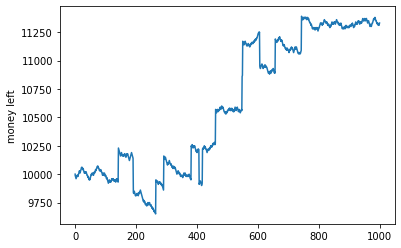

In [1355]:
plt.plot(index,money_show)
plt.ylabel('money left')
plt.show()

## 추가 과제 : 플레이어의 승률 높이기
State를 수정하여 승률이 더 높은 policy를 찾기

기존 코드의 수정 필요
 - 딜러는 게임이 끝났을 때, 남은 카드의 수를 확인
 - 15장 이상이라면 해당 덱을 다음 게임에서 그대로 사용
 - 15장 미만이라면 52장의 셔플된 새로운 카드를 기존 덱에 추가



---
### 참고자료
[1] Reinforcement Learning - An Introduction (Richard S. Sutton, Andreow G. Barto), 2nd edition, p.120-124 https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf <br>
[2] matplotlib.pyplot.plot Documentation, https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html <br>
[3] matplotlib.pyplot.plot Examples https://matplotlib.org/tutorials/introductory/pyplot.html